In [2]:
import tensorflow as tf
import tensorflow_hub as hub

In [3]:
import matplotlib.pyplot as plt
import tempfile
from six.moves.urllib.request import urlopen
from six import BytesIO

In [4]:
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

In [5]:
# Print Tensorflow version
print(tf.__version__)

2.0.0


In [6]:
# Check available GPU devices.
print("The following GPU devices are available: %s" % tf.test.gpu_device_name())

The following GPU devices are available: 


2022-02-05 10:16:30.060062: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
def display_image(image):
  fig = plt.figure(figsize=(20, 15))
  plt.grid(False)
  plt.imshow(image)


def download_and_resize_image(url, new_width=256, new_height=256,
                              display=False):
  _, filename = tempfile.mkstemp(suffix=".jpg")
  response = urlopen(url)
  image_data = response.read()
  image_data = BytesIO(image_data)
  pil_image = Image.open(image_data)
  pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)
  pil_image_rgb = pil_image.convert("RGB")
  pil_image_rgb.save(filename, format="JPEG", quality=90)
  print("Image downloaded to %s." % filename)
  if display:
    display_image(pil_image)
  return filename


def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):
  """Adds a bounding box to an image."""
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)

  # If the total height of the display strings added to the top of the bounding
  # box exceeds the top of the image, stack the strings below the bounding box
  # instead of above.
  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
  # Each display_str has a top and bottom margin of 0.05x.
  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = top + total_display_str_height
  # Reverse list and print from bottom to top.
  for display_str in display_str_list[::-1]:
    text_width, text_height = font.getsize(display_str)
    margin = np.ceil(0.05 * text_height)
    draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                    (left + text_width, text_bottom)],
                   fill=color)
    draw.text((left + margin, text_bottom - text_height - margin),
              display_str,
              fill="black",
              font=font)
    text_bottom -= text_height - 2 * margin


def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.1):
  """Overlay labeled boxes on an image with formatted scores and label names."""
  colors = list(ImageColor.colormap.values())

  try:
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                              25)
  except IOError:
    print("Font not found, using default font.")
    font = ImageFont.load_default()

  for i in range(min(boxes.shape[0], max_boxes)):
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i])
      display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                     int(100 * scores[i]))
      color = colors[hash(class_names[i]) % len(colors)]
      image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
      draw_bounding_box_on_image(
          image_pil,
          ymin,
          xmin,
          ymax,
          xmax,
          color,
          font,
          display_str_list=[display_str])
      np.copyto(image, np.array(image_pil))
  return image

In [11]:
url       = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"
detector  = hub.load(url).signatures['default']
print(url)


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
2022-02-05 10:25:43.517883: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1


In [20]:
img_url = "https://www.beylikduzu.istanbul/BBImages/Slider/Image/%E2%80%98pazar-istanbulda-ilk-pazar-kuruldu-4.JPG"
width  = 2122
height = 1414
downloaded_image_path = download_and_resize_image(img_url, width, height)

Image downloaded to /var/folders/54/ky7_pryx48j8gkqscmdnwlwc0000gn/T/tmp34cs8kgs.jpg.


In [21]:
print("Image Path : ",downloaded_image_path)

Image Path :  /var/folders/54/ky7_pryx48j8gkqscmdnwlwc0000gn/T/tmp34cs8kgs.jpg


In [22]:
def load_img(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  return img 

In [23]:
img_dublin = load_img(downloaded_image_path)
img_dublin_predict = tf.image.convert_image_dtype(img_dublin, tf.float32)[tf.newaxis, ...]
result     = detector(img_dublin_predict)

In [24]:
r = {key : value.numpy() for key , value in result.items()}

In [25]:
print("Type of result : ",type(result))
print("keys : ",result.keys())

Type of result :  <class 'dict'>
keys :  dict_keys(['detection_class_entities', 'detection_scores', 'detection_class_labels', 'detection_boxes', 'detection_class_names'])


In [26]:
img_dublin_box = draw_boxes(
      img_dublin.numpy(), r["detection_boxes"],
      r["detection_class_entities"], r["detection_scores"])

Font not found, using default font.


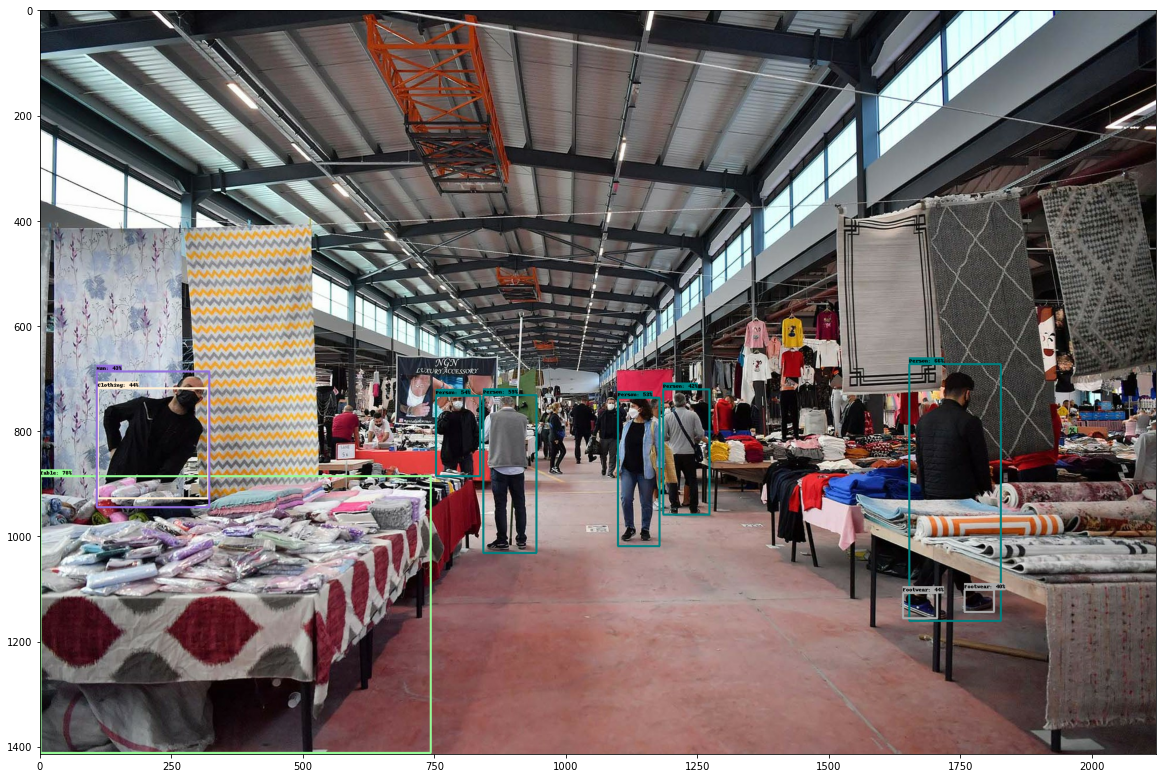

In [29]:
display_image(img_dublin_box)